# Sec Recon Analyses

Here we perform different analyses to test the quality of secRecon

In [1]:
import datetime
import pickle
import networkx as nx

import re
import pandas as pd
import numpy as np
from Bio import Entrez
import Request_Utilis
from google_sheet import GoogleSheet
from collections import defaultdict
from scipy import interpolate

# Plotting libraries
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
from itertools import product

# Warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### Load data

In [2]:
##### ----- Generate datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
Sec_Recon_SPREADSHEET_ID = '1L6qQQs48OdFd-mJcVqov_rSDoV90Ta0kib6UpL81OJQ'

# Initialize the GoogleSheet object
sec_recon_gsheet_file = GoogleSheet(Sec_Recon_SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from SecRecon
sec_genes_sheet = 'SecRecon'
ontology_sheet = 'Ontology'

sec_genes = sec_recon_gsheet_file.read_google_sheet(sec_genes_sheet)
ontology = sec_recon_gsheet_file.read_google_sheet(ontology_sheet)

In [3]:
# Load datasets
cho_vs_plasma_prot_upreg = pd.read_excel('Data/cho_vs_plasma/secrecon_1-s2.0-S1096717624000521-mmc3.xlsx',
                                   sheet_name = 'upreg-PCDvCHO_Prot')

cho_vs_plasma_prot_downreg = pd.read_excel('Data/cho_vs_plasma/secrecon_1-s2.0-S1096717624000521-mmc3.xlsx',
                                   sheet_name = 'downreg-PCDvCHO_Prot')

cho_vs_plasma_rna_upreg = pd.read_excel('Data/cho_vs_plasma/secrecon_1-s2.0-S1096717624000521-mmc3.xlsx',
                                   sheet_name = 'upreg-MurinevCHO_RNA')

cho_vs_plasma_rna_downreg = pd.read_excel('Data/cho_vs_plasma/secrecon_1-s2.0-S1096717624000521-mmc3.xlsx',
                                   sheet_name = 'downreg-MurinevCHO_RNA')

In [4]:
# Load gene_dict from SecRecon

with open('gene_dict.pkl', 'rb') as f:
    gene_dict = pickle.load(f)

In [5]:
# Load G string for plotting
G = nx.read_graphml('Network/sec_recon_network.graphml')

### Preprocessing of the data
In this section we'll use the networks generated in the Network_visualization notebook to visualize experimental data from a CHO High vs Low dataset

In [6]:
data_type = ['prot_upreg', 'prot_downreg', 'rna_upreg', 'rna_downreg']
data = data_type[0]

if data == 'prot_upreg':
    df = cho_vs_plasma_prot_upreg
elif data == 'prot_downreg':
    df = cho_vs_plasma_prot_downreg
elif data == 'rna_upreg':
    df = cho_vs_plasma_rna_upreg
elif data == 'rna_downreg':
    df = cho_vs_plasma_rna_downreg

In [7]:
# Map Mouse genes to Human genes

dict_mouse_human = dict(zip(sec_genes['MOUSE GENE SYMBOL'], sec_genes['GENE SYMBOL']))
df['Human_Genes'] = df['Mmus_Genes'].map(dict_mouse_human)

In [8]:
# Filtering

# Filter rows where 'Human_Genes' is not NaN
filtered_df = df[df['Human_Genes'].notna()]

# Filter the dictionary based on the filtered_df
filtered_gene_dict = {gene: info for gene, info in gene_dict.items() if gene in filtered_df['Human_Genes'].values}

# Filter the graph G based on the filtered_gene_dict
nodes_to_remove = [node for node in G.nodes if node not in filtered_gene_dict]
G.remove_nodes_from(nodes_to_remove)

# Extract positions from the graph
pos = {node: (float(data['x']), float(data['y'])) for node, data in G.nodes(data=True)}

In [9]:
if (data == 'prot_upreg') or (data == 'prot_downreg'):
    filtered_df['log2_abs'] = abs(filtered_df['log2_FC PCD/CHO'])
elif (data == 'rna_upreg') or (data == 'rna_downreg'):
    filtered_df['log2_abs'] = abs(filtered_df['log2_Fold-Change Murine/CHO'])

/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_2603/1239230728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['log2_abs'] = abs(filtered_df['log2_FC PCD/CHO'])


In [10]:
# Normalization

min_val = 0.001
max_val = 0.035

filtered_df['normalized_log'] = ((filtered_df['log2_abs'] - filtered_df['log2_abs'].min()) / 
                                (filtered_df['log2_abs'].max() - filtered_df['log2_abs'].min())) * (max_val - min_val) + min_val


/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_2603/411015644.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['normalized_log'] = ((filtered_df['log2_abs'] - filtered_df['log2_abs'].min()) /


In [11]:
# Add expression data to the gene_dict

for i,row in filtered_df.iterrows():
    g = row['Human_Genes']
    if g in gene_dict.keys():
        filtered_gene_dict[g]['Expression'] = float(row['normalized_log'])

In [12]:
# Discretize the size of the nodes by allocating the radius into 3 different categories

# Fit an interpolation function
x = filtered_df['log2_abs']
y = filtered_df['normalized_log']
interp_func = interpolate.interp1d(x, y, fill_value="extrapolate")

# Define cutoff values for FC PCD/CHO
cutoff_values = [0, 2, 4, np.inf]

# Interpolate the cutoffs to normalized_log values
normalized_cutoffs = []
for cutoff in cutoff_values:
    if np.isfinite(cutoff):
        normalized_cutoffs.append(float(interp_func(cutoff)))
    else:
        normalized_cutoffs.append(cutoff)

# Create categories for node sizes
categories = {
    (-np.inf, normalized_cutoffs[1]): 0.005,
    (normalized_cutoffs[1], normalized_cutoffs[2]): 0.020,
    (normalized_cutoffs[2], normalized_cutoffs[3]): 0.035,
}

/Users/pablodigiusto/miniforge3/envs/secrecon2.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [13]:
def get_radius(value):
    for (low, high), radius in categories.items():
        if low <= value < high:
            return radius
    return 0.001  # Default small value if out of range

### 2. Plotting on secRecon Ontology

In [ ]:
system_colors = {
    'Protein conformation': (1.0, 0.6, 0.0, 1.0),
    'Post-translational modifications': (0.1, 0.9, 0.1, 1.0), 
    'Proteostasis': (0.3, 0.3, 0.9, 1.0),
    'Translocation': (0.4, 0.7, 0.9, 1.0),
    'Vesicle trafficking': (0.7, 0.7, 0.3, 1.0)
}

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(40, 40))

# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 1]

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey')#, 
                       #width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 2])

    
# Draw nodes as pie charts
for node, (x, y) in pos.items():
    systems = gene_dict[node]['systems']
    
    # Adjust the alpha value of each color
    colors = [system_colors[sys] for sys in systems]
    
    # Draw pie chart at node position with edgecolor and linewidth
    raw_radius = filtered_gene_dict[node]['Expression']
    radius = get_radius(raw_radius)
    ax.pie([1]*len(systems), colors=colors, radius=radius, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    
# Get the current axis limits
x_values, y_values = zip(*pos.values())
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Set new axis limits
ax.set_xlim(min_x - 0.1, max_x + 0.1)
ax.set_ylim(min_y - 0.1, max_y + 0.1)

# Legend for node colors
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in system_colors.items()]
color_legend = plt.legend(handles=legend_patches, prop={'size': 30}, loc='lower left', bbox_to_anchor=(0.05, 0.05), title="System" , title_fontsize=35)

# Create custom legend handles for node sizes
size_legend_patches = []
size_labels = ['0 to 2', '2 to 4', '> 4']
scaling_factor = 1800

for (low, high), radius, label in zip(categories.keys(), categories.values(), size_labels):
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=radius * scaling_factor, label=label)
    size_legend_patches.append(handle)

# Add the second legend for node sizes
size_legend = plt.legend(handles=size_legend_patches, prop={'size': 35}, loc='lower left', bbox_to_anchor=(0.8, 0.75), title="Log2 Fold Change", title_fontsize=35)

# Add both legends to the plot
ax.add_artist(color_legend)
ax.add_artist(size_legend)

plt.subplots_adjust(right=0.75)

plt.savefig(f'Network_cho_vs_plasma/secRecon_cho_vs_plasma_systems_{data}.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [ ]:
localization_colors = {
    'Actin Cytoskeleton': (0.7, 0.4, 0.2, 1.0),
    'Centrosome': (0.0, 0.5, 0.5, 1.0),
    'ERGIC': (1.0, 0.6, 0.0, 1.0),
    'Endosome': (0.0, 0.7, 0.3, 1.0), 
    'Recycling Endosome': (0.3, 0.0, 0.7, 1.0),
    'Late Endosome': (0.8, 0.0, 0.5, 1.0),
    'Early Endosome': (0.7, 0.0, 0.4, 1.0), 
    'Plasma Membrane': (0.5, 0.5, 0.0, 1.0), 
    'Golgi': (0.1, 0.9, 0.1, 1.0), 
    'cis-Golgi': (0.2, 0.8, 0.6, 1.0),
    'trans-Golgi': (0.4, 0.8, 0.4, 1.0), 
    'Nucleus': (0.9, 0.1, 0.1, 1.0),
    'Nucleolus': (0.5, 0.1, 0.1, 1.0),
    'Phagosome': (0.6, 0.3, 0.0, 1.0),
    'Proteasome': (0.3, 0.3, 0.9, 1.0),
    'Mitochondria': (0.9, 0.5, 0.5, 1.0),
    'Lysosome': (0.5, 0.9, 0.8, 1.0),  
    'Cytosol': (0.3, 0.8, 0.95, 1.0),
    'Cytoplasm': (0.4, 0.7, 0.9, 1.0),
    'Endoplasmic Reticulum': (0.7, 0.7, 0.3, 1.0),
    'Secreted': (0.8, 0.4, 0.0, 1.0),
    'Stress Granule': (0.9, 0.3, 0.05, 1.0),
    'Translation': (0.8, 0.2, 0.8, 1.0),
    'Unknown': (0.0, 0.0, 0.0, 1.0)
}

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(40, 40))

# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 1]

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey')#, 
                       #width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 2])


# Draw nodes as pie charts
for node, (x, y) in pos.items():
    localizations = gene_dict[node]['subcellular_localization']
    
    # Adjust the alpha value of each color
    colors = [localization_colors[loc] for loc in localizations]
    
    # Draw pie chart at node position with edgecolor and linewidth
    raw_radius = filtered_gene_dict[node]['Expression']
    radius = get_radius(raw_radius)
    ax.pie([1]*len(systems), colors=colors, radius=radius, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    
# Get the current axis limits
x_values, y_values = zip(*pos.values())
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Set new axis limits
ax.set_xlim(min_x - 0.1, max_x + 0.1)
ax.set_ylim(min_y - 0.1, max_y + 0.1)

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in localization_colors.items()]
color_legend = plt.legend(handles=legend_patches, prop={'size': 25}, loc='lower left', bbox_to_anchor=(0.75, 0.4), title="Subcellular Localization" , title_fontsize=35)

# Create custom legend handles for node sizes
size_legend_patches = []
size_labels = ['0 to 2', '2 to 4', '> 4']
scaling_factor = 1800

for (low, high), radius, label in zip(categories.keys(), categories.values(), size_labels):
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=radius * scaling_factor, label=label)
    size_legend_patches.append(handle)

# Add the second legend for node sizes
size_legend = plt.legend(handles=size_legend_patches, prop={'size': 40}, loc='lower left', bbox_to_anchor=(0.1, 0.1), title="Log2 Fold Change", title_fontsize=35)

# Add both legends to the plot
ax.add_artist(color_legend)
ax.add_artist(size_legend)

plt.subplots_adjust(right=0.75)

plt.savefig(f'Network_cho_vs_plasma/secRecon_cho_vs_plasma_localization_{data}.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

### 3. Plotting on Protein-Protein Interactions

In [ ]:
from pp_interactions import visualize_network

In [14]:
G_ppi = nx.read_graphml('Network/string_interactions_sec_recon.graphml')

# Filter the G PPI based on the filtered_gene_dict
nodes_to_remove = [node for node in G_ppi.nodes if node not in filtered_gene_dict]
G_ppi.remove_nodes_from(nodes_to_remove)

# Extract positions from the graph
pos = {node: (float(data['x']), float(data['y'])) for node, data in G_ppi.nodes(data=True)}

In [ ]:
filename = f"Network_cho_vs_plasma/STRING_cho_vs_plasma_systems_{data}.png"
visualize_network(G_ppi, filtered_gene_dict, pos, filename=filename, node_size='exp', color_by='systems', legends=True, categories=categories)

In [ ]:
filename = f"Network_cho_vs_plasma/STRING_cho_vs_plasma_localization_{data}.png"
visualize_network(G_ppi, filtered_gene_dict, pos, filename=filename, node_size='exp', color_by='localization', legends=True, categories=categories)

In [ ]:
# Limitations:
# 20% representation of secRecon
# 50% in transcriptomics??

### 4. Subset of enriched processes on GSVA analysis

#### 4.1 Functional Topology

In [ ]:
gsva_colors = {
    'ERpQC': (1.0, 0.3, 0.0, 1.0),  # Bright Orange
    'Vesicle budding': (0.3, 0.9, 0.1, 1.0),  # Light Green
    'ER stress response/UPR': (0.2, 0.6, 1.0, 1.0),  # Light Blue
    'MAPS': (0.9, 0.2, 0.5, 1.0),  # Pink
    'Translocation': (0.7, 0.3, 0.9, 1.0),  # Purple
    'N-glycan': (0.4, 0.7, 0.2, 1.0),  # Olive Green
    'Other': (0.7, 0.7, 0.7, 0.7)  # Gray
}

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(40, 40))

# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 1]

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey')#, 
                       #width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 2])

# Draw nodes as pie charts
for node, (x, y) in pos.items():
    processes = gene_dict[node]['processes']
    subsystems = gene_dict[node]['subsystems']
    systems = gene_dict[node]['systems']
    ontology = processes + subsystems + systems

    # Select the first matching color from gsva_colors, defaulting to 'Other' if no match is found
    node_color = gsva_colors['Other']  # Default to gray
    for prc in ontology:
        if prc in gsva_colors:
            node_color = gsva_colors[prc]
            break  # Stop at the first match
    
    # Draw pie chart at node position with edgecolor and linewidth
    raw_radius = filtered_gene_dict[node]['Expression']
    radius = get_radius(raw_radius)
    
    # Draw a single colored circle at the node position
    circle = plt.Circle((x, y), radius, color=node_color, ec='black', lw=0.5)
    ax.add_patch(circle)
    
# Get the current axis limits
x_values, y_values = zip(*pos.values())
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Set new axis limits
ax.set_xlim(min_x - 0.1, max_x + 0.1)
ax.set_ylim(min_y - 0.1, max_y + 0.1)

# Legend for node colors
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in gsva_colors.items()]
color_legend = plt.legend(handles=legend_patches, prop={'size': 30}, loc='lower left', bbox_to_anchor=(0.05, 0.05), title="System" , title_fontsize=35)

# Create custom legend handles for node sizes
size_legend_patches = []
size_labels = ['0 to 2', '2 to 4', '> 4']
scaling_factor = 1800

for (low, high), radius, label in zip(categories.keys(), categories.values(), size_labels):
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=radius * scaling_factor, label=label)
    size_legend_patches.append(handle)

# Add the second legend for node sizes
size_legend = plt.legend(handles=size_legend_patches, prop={'size': 35}, loc='lower left', bbox_to_anchor=(0.8, 0.75), title="Log2 Fold Change", title_fontsize=35)

# Add both legends to the plot
ax.add_artist(color_legend)
ax.add_artist(size_legend)

plt.subplots_adjust(right=0.75)

plt.savefig(f'Network_cho_vs_plasma/secRecon_gsva_systems_{data}.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

#### 4.2 PPI Topology

In [15]:
def get_radius(value, categories):
    """
    Determine the radius of the node based on the normalized_log value.
    
    Parameters:
    value (float): The normalized_log value of the node.
    
    Returns:
    float: The radius corresponding to the given value based on predefined categories.
    """
    # Iterate over the categories to find the appropriate radius for the given value
    for (low, high), radius in categories.items():
        if low <= value < high:
            return radius
    
    # Return a default small value if the value does not fit into any category
    return 0.001

def visualize_network(G, gene_dict, pos, node_size=0.010, filename=None, color_by='systems', legends=True, categories=None, custom_color_dict=None):
    """
    Visualize a protein-protein interaction network using matplotlib.

    Parameters:
    - G (networkx.Graph): The graph to visualize.
    - pos (dict): Positions of nodes.
    - gene_dict (dict): Dictionary containing gene information.
    - node_size (float, optional): Size of the nodes.
    - filename (str, optional): If provided, save the plot to this filename.
    - color_by (str, optional): Attribute to color nodes by ('systems' or 'localization').
    - legends (bool, optional): Whether to display legends.
    """
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(40, 40))

    # Scale edge widths
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    min_width = 0.1
    max_width = 4.0
    epsilon = 1e-10
    if edge_weights:
        edge_weights = [min_width + (w - min(edge_weights)) * (max_width - min_width) / (max(edge_weights) - min(edge_weights) + epsilon) for w in edge_weights]

    # Draw edges with scaled widths
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='lightgray', ax=ax)

    # Draw nodes as pie charts
    if color_by == 'systems':
        for node, (x, y) in pos.items():
            systems = gene_dict[node]['systems']
            colors = [system_colors[sys] for sys in systems]

            if node_size == 'exp':
                # Draw pie chart at node position with edgecolor and linewidth
                raw_radius = gene_dict[node]['Expression']
                radius = get_radius(raw_radius, categories)
                ax.pie([1]*len(systems), colors=colors, radius=radius, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
            else:
                ax.pie([1]*len(systems), colors=colors, radius=node_size, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))

    elif color_by == 'localization':
        for node, (x, y) in pos.items():
            localizations = gene_dict[node]['subcellular_localization']
            colors = [localization_colors[loc] for loc in localizations]

            if node_size == 'exp':
                # Draw pie chart at node position with edgecolor and linewidth
                raw_radius = gene_dict[node]['Expression']
                radius = get_radius(raw_radius, categories)
                ax.pie([1]*len(localizations), colors=colors, radius=radius, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
            else:
                ax.pie([1]*len(localizations), colors=colors, radius=0.012, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
                
    elif color_by == 'custom_systems':
        for node, (x, y) in pos.items():
            processes = gene_dict[node]['processes']
    
            if 'Membrane fusion' in gene_dict[node]['subsystems']:
                processes.append('Membrane fusion')

            # Set colors    
            label_node = False  # Initialize label flag
            
            processes = gene_dict[node]['processes']
            subsystems = gene_dict[node]['subsystems']
            systems = gene_dict[node]['systems']
            ontology = processes + subsystems + systems

            # Select the first matching color from gsva_colors, defaulting to 'Other' if no match is found
            node_color = gsva_colors['Other']  # Default to gray
            for prc in ontology:
                if prc in gsva_colors:
                    node_color = gsva_colors[prc]
                    label_node = True  # Set label flag if process has a defined color excluding 'Other'
                    break  # Stop at the first match
                    
            if node_size == 'exp':
                # Draw pie chart at node position with edgecolor and linewidth
                raw_radius = filtered_gene_dict[node]['Expression']
                radius = get_radius(raw_radius, categories)
            else:
                radius = node_size

            # Draw a single colored circle at the node position
            circle = plt.Circle((x, y), radius, color=node_color, ec='black', lw=0.5)
            ax.add_patch(circle)
            
            # Add labels to nodes if they are not categorized as 'Other'
            # Add label if applicable
            if label_node and (radius>0.005):
                ax.text(x + radius * 1.2, y + radius * 1.2, str(node), fontsize=25, ha='center', va='center', color='black', fontweight='bold', zorder=5)

    # Get the current axis limits
    x_values, y_values = zip(*pos.values())
    min_x, max_x = min(x_values), max(x_values)
    min_y, max_y = min(y_values), max(y_values)

    # Set new axis limits
    ax.set_xlim(min_x - 0.1, max_x + 0.1)
    ax.set_ylim(min_y - 0.1, max_y + 0.1)

    # Legend
    if legends:
        if color_by == 'systems':
            legend_patches = [mpatches.Patch(color=color, label=category) for category, color in system_colors.items()]
            color_legend = plt.legend(handles=legend_patches, prop={'size': 30}, loc='lower left', bbox_to_anchor=(0.6, 0.8), title="System" , title_fontsize=35)
        elif color_by == 'localization':
            legend_patches = [mpatches.Patch(color=color, label=category) for category, color in localization_colors.items()]
            color_legend = plt.legend(handles=legend_patches, prop={'size': 25}, loc='lower left', bbox_to_anchor=(0.7, 0.4), title="Subcellular Localization" , title_fontsize=35)
        elif color_by == 'custom_systems':
            legend_patches = [mpatches.Patch(color=color, label=category) for category, color in custom_color_dict.items()]
            color_legend = plt.legend(handles=legend_patches, prop={'size': 30}, loc='lower left', bbox_to_anchor=(0.6, 0.8), title="System" , title_fontsize=35)

        # Create custom legend handles for node sizes
        size_legend_patches = []
        size_labels = ['0 to 2', '2 to 4', '> 4']
        scaling_factor = 1800

        for (low, high), radius, label in zip(categories.keys(), categories.values(), size_labels):
            handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=radius * scaling_factor, label=label)
            size_legend_patches.append(handle)

        # Add the second legend for node sizes
        size_legend = plt.legend(handles=size_legend_patches, prop={'size': 40}, loc='lower left', bbox_to_anchor=(0, 0.3), title="Log2 Fold Change", title_fontsize=35)

        # Add both legends to the plot
        ax.add_artist(color_legend)
        ax.add_artist(size_legend)

        plt.subplots_adjust(right=0.75)

    if filename:
        plt.savefig(filename, format='svg', dpi=300, bbox_inches='tight')

    plt.show()

In [16]:
gsva_colors = {
    'ERpQC': (1.0, 0.3, 0.0, 1.0),  # Bright Orange
    'Vesicle budding': (0.3, 0.9, 0.1, 1.0),  # Light Green
    'ER stress response/UPR': (0.2, 0.6, 1.0, 1.0),  # Light Blue
    'MAPS': (0.9, 0.2, 0.5, 1.0),  # Pink
    'Translocation': (0.7, 0.3, 0.9, 1.0),  # Purple
    'N-glycan': (0.4, 0.7, 0.2, 1.0),  # Olive Green
    'Other': (0.7, 0.7, 0.7, 0.7)  # Gray
}

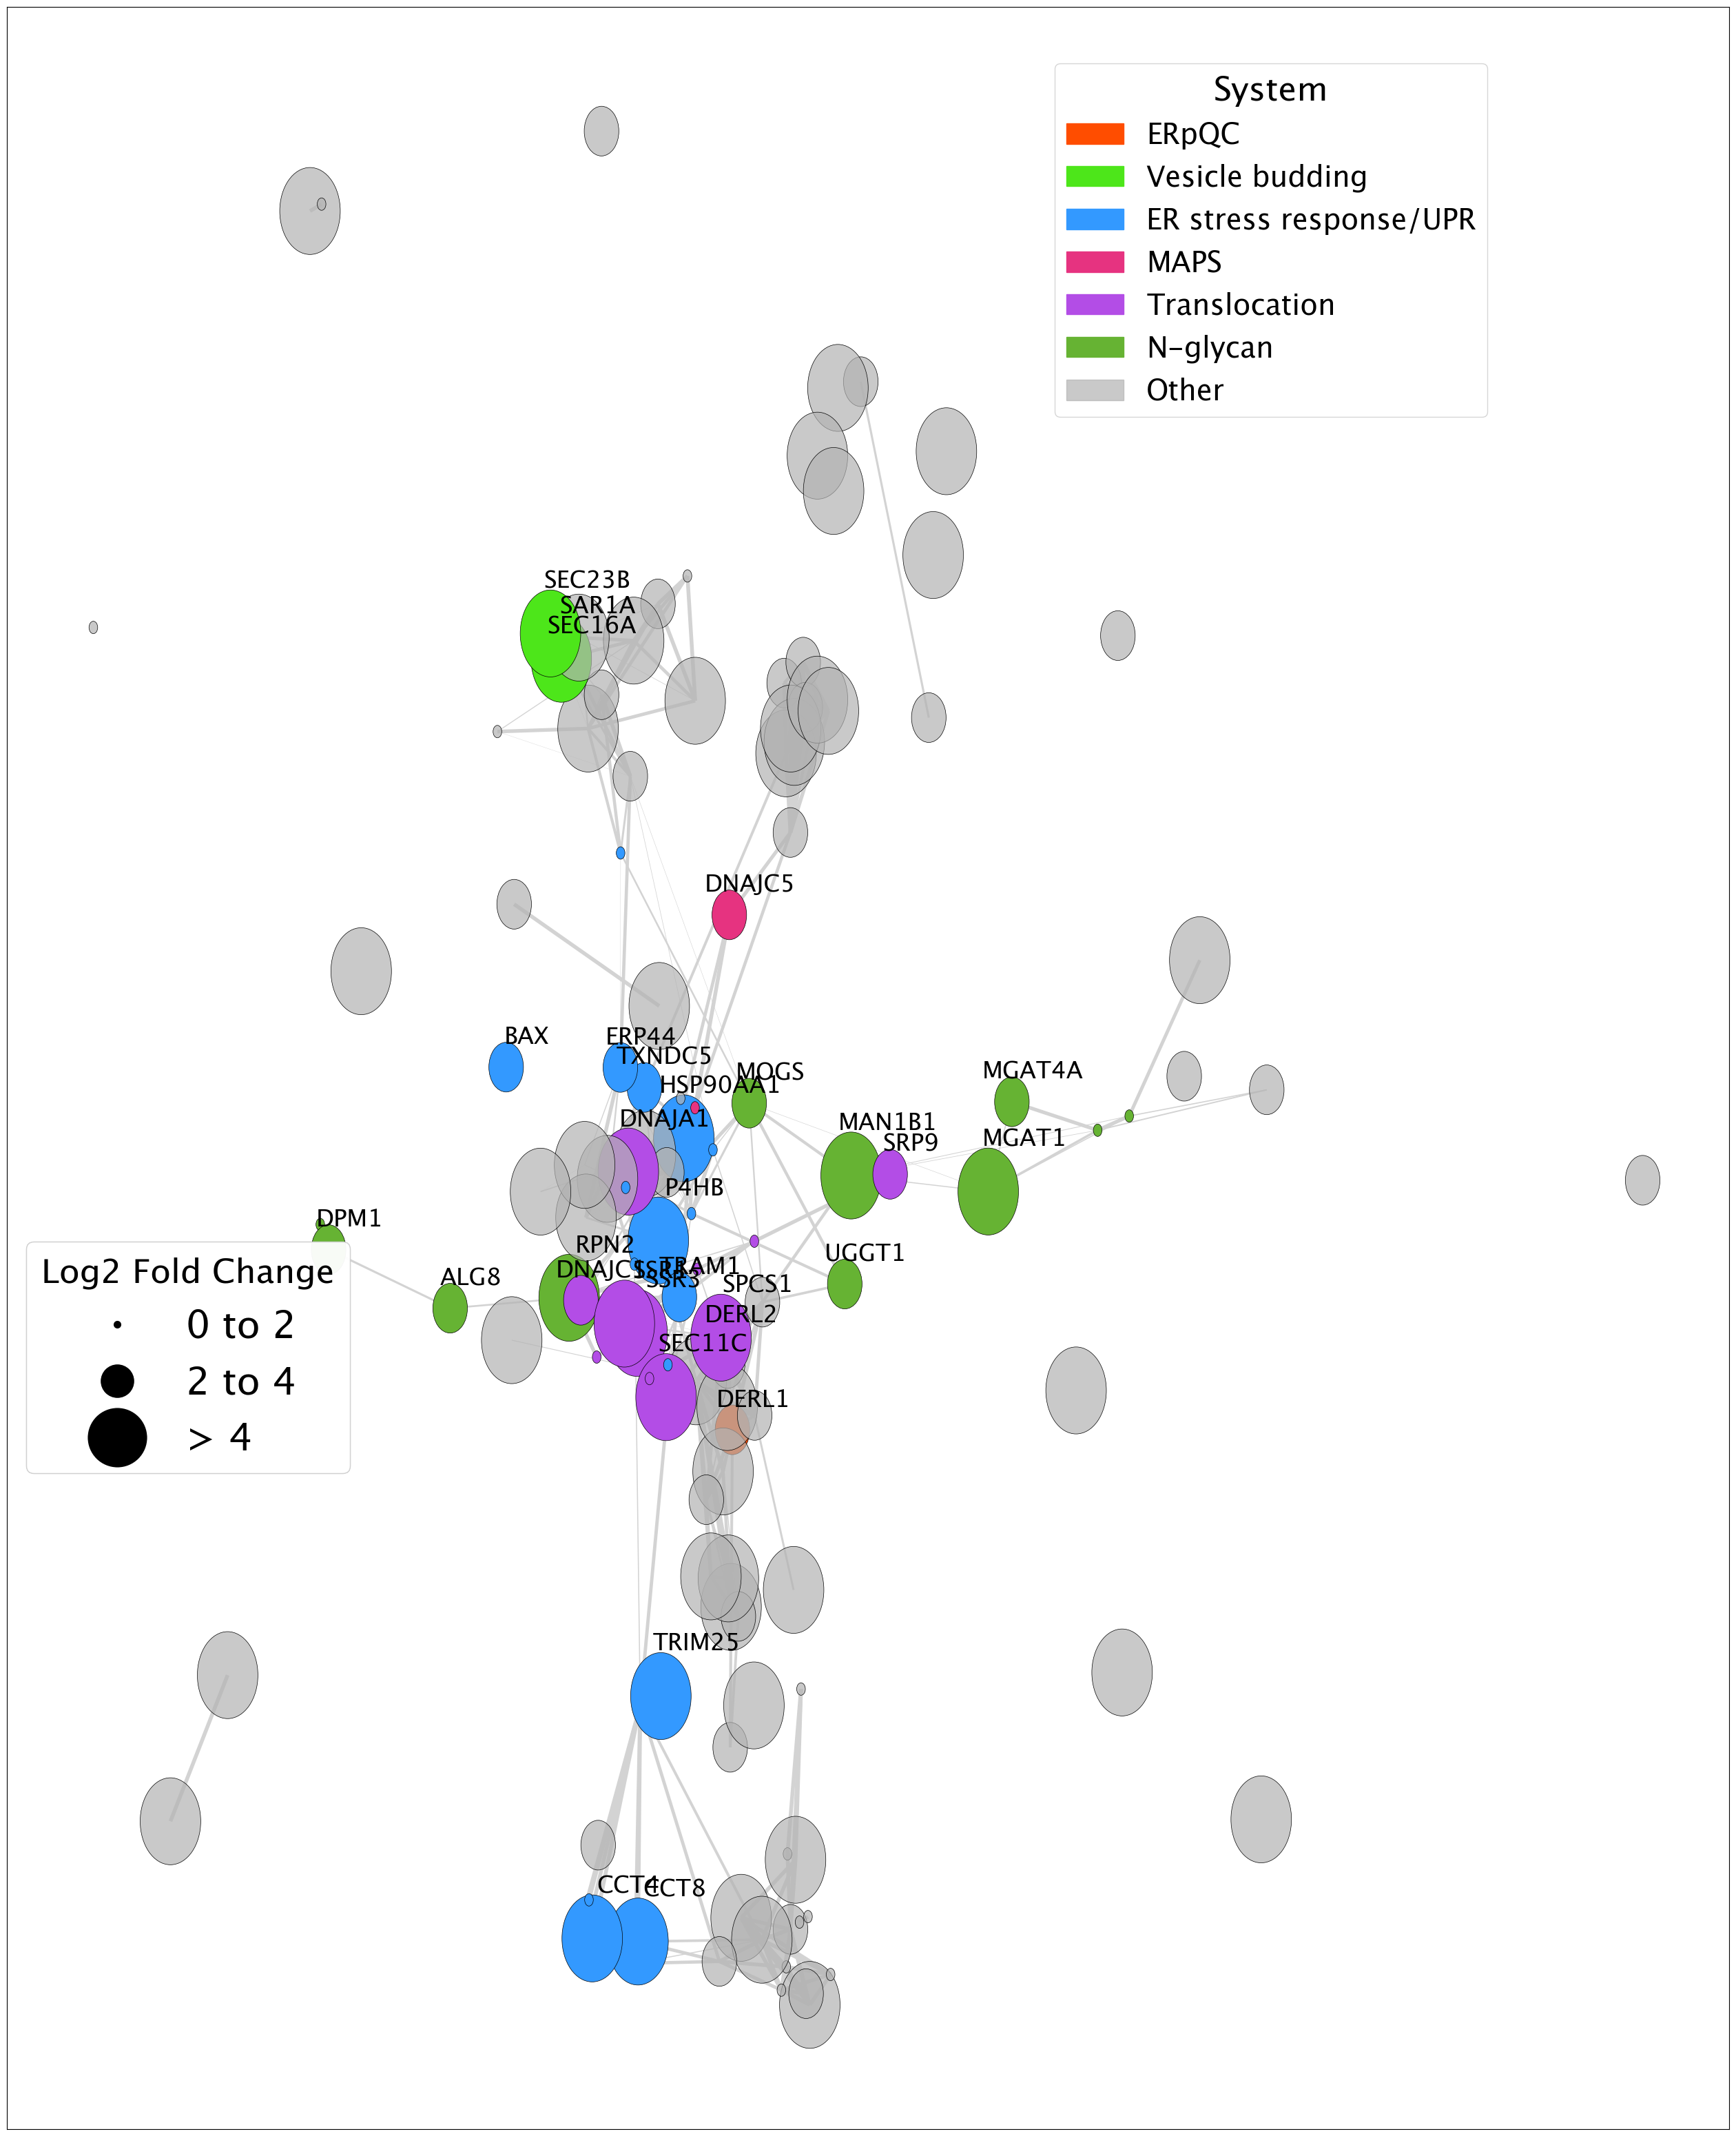

In [17]:
filename = f"Network_cho_vs_plasma/STRING_gsva_systems_{data}.svg"
visualize_network(G_ppi, gene_dict, pos, filename=filename, color_by='custom_systems', node_size='exp', legends=True, categories=categories, custom_color_dict=gsva_colors)